## Imports

In [250]:
from adodbapi.apibase import pythonTimeConverter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score, classification_report, confusion_matrix
import re
from collections import defaultdict
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from xgboost import XGBClassifier
from sklearn.preprocessing import label_binarize
import os
from tqdm import tqdm
import shap
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter
import zipfile
import gdown
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Data preprocessing

In [251]:
def apply_smote(labeled_x, labeled_y, random_state=42):
    """
    Applies SMOTE oversampling to balance class distribution in labeled data.

    Args:
        labeled_x (np.ndarray): Feature array of shape (n_samples, ...) for labeled data.
        labeled_y (np.ndarray): Corresponding class labels.
        random_state (int): Random seed for reproducibility.

    Returns:
        X_resampled (np.ndarray): Resampled feature array in original shape.
        y_resampled (np.ndarray): Resampled labels.
    """
    print("Original class distribution:", Counter(labeled_y))

    X = labeled_x.reshape((labeled_x.shape[0], -1))

    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, labeled_y)

    print("Resampled class distribution:", Counter(y_resampled))

    original_shape = labeled_x.shape[1:]
    X_resampled = X_resampled.reshape((X_resampled.shape[0],) + original_shape)

    return X_resampled, y_resampled
def find_knn_per_class_fixed(
    labeled_x, labeled_y,
    unlabeled_x, unlabeled_meta=None,
    target_class=0,
    n_to_add=20,
    max_K=10,
    distance_threshold=50
):
    """
    For labeled samples of a given class, find neighbors in unlabeled_x
    and select the n_to_add closest ones total for the class.

    Returns:
    - results: list of neighbor info per labeled sample
    - new_labeled_x: np.ndarray of new samples
    - new_labeled_y: np.ndarray of pseudo-labels (same as target_class)
    - updated_unlabeled_x: np.ndarray of unlabeled_x with selected neighbors removed
    - updated_unlabeled_meta: same shape as unlabeled_meta (if given), else None
    """
    import numpy as np
    from sklearn.neighbors import NearestNeighbors

    class_mask = labeled_y == target_class
    class_x = labeled_x[class_mask]
    class_indices = np.where(class_mask)[0]

    if len(unlabeled_x) == 0:
        return [], np.empty((0, labeled_x.shape[1])), np.array([]), unlabeled_x, unlabeled_meta

    nn = NearestNeighbors(n_neighbors=min(max_K * 3, len(unlabeled_x)), metric='euclidean')
    nn.fit(unlabeled_x)

    all_candidates = []
    candidate_sources = []

    for l_idx, sample in zip(class_indices, class_x):
        dists, nbrs = nn.kneighbors(sample.reshape(1, -1), return_distance=True)
        dists = dists[0]
        nbrs = nbrs[0]

        for i, d in zip(nbrs, dists):
            if 0 < d <= distance_threshold:
                all_candidates.append((i, d))
                candidate_sources.append((l_idx, sample))

    if not all_candidates:
        return [], np.empty((0, labeled_x.shape[1])), np.array([]), unlabeled_x, unlabeled_meta

    # Sort all candidate neighbors by distance
    all_candidates_sorted = sorted(all_candidates, key=lambda x: x[1])

    # Keep only the nearest n_to_add samples (without repetition)
    selected_indices = []
    used_unlabeled = set()

    for i, (unlabeled_idx, dist) in enumerate(all_candidates_sorted):
        if unlabeled_idx not in used_unlabeled:
            selected_indices.append(unlabeled_idx)
            used_unlabeled.add(unlabeled_idx)
        if len(selected_indices) >= n_to_add:
            break

    # Prepare new labeled data
    new_labeled_x = unlabeled_x[selected_indices]
    new_labeled_y = np.full(len(new_labeled_x), target_class)

    # Remove selected from unlabeled_x and unlabeled_meta
    mask = np.ones(len(unlabeled_x), dtype=bool)
    mask[selected_indices] = False
    updated_unlabeled_x = unlabeled_x[mask]

    if unlabeled_meta is not None:
        updated_unlabeled_meta = unlabeled_meta[mask]
    else:
        updated_unlabeled_meta = None

    # For info/debugging
    results = {
        'selected_indices': selected_indices,
        'num_added': len(selected_indices)
    }

    return results, new_labeled_x, new_labeled_y, updated_unlabeled_x, updated_unlabeled_meta


In [252]:
class LabeledAcousticDataset(Dataset):
    def __init__(self, base_folder, feature_columns=None, id_columns=('File', 'Minute', 'Time')):
        self.base_folder = base_folder
        self.id_columns = id_columns
        self.feature_columns = feature_columns or [
            'ClksThisMin', 'medianKHz', 'avSPL', 'avPkAt', 'AvPRF', 'avEndF',
            'tWUTrisk', 'nActualClx', 'nRisingIPIs', 'TrDur_us', 'nICIrising',
            'MinICI_us', 'midpointICI', 'MaxICI_us', 'ClkNofMinICI', 'ClkNofMaxICI',
            'NofClstrs', 'avClstrNx8', 'avPkIPI', 'BeforeIPIratio', 'PreIPIratio',
            'Post1IPIratio', 'Post2IPIratio', 'EndIPIratio'
        ]

        self.labeled_data, self.labels = self._load_all_labeled_data()

    def _load_all_labeled_data(self):
        labeled_data = []
        labels = []

        label_map = {
            "FeedingBuzzes": 0,
            "NonFeedingClickTrains": 1
        }

        for class_folder, label in label_map.items():
            folder_path = os.path.join(self.base_folder, class_folder)
            excel_file = os.path.join(folder_path, f"{class_folder}.xlsx")

            if not os.path.exists(excel_file):
                raise FileNotFoundError(f"Excel file not found: {excel_file}")

            df = pd.read_excel(excel_file)

            # Ensure alignment with ID columns
            df[self.id_columns[0]] = df[self.id_columns[0]].astype(str)
            df[self.id_columns[1]] = df[self.id_columns[1]].astype(int)
            df[self.id_columns[2]] = df[self.id_columns[2]].astype(int)

            df['label'] = label
            labeled_data.append(df)
            labels.extend([label] * len(df))

        full_df = pd.concat(labeled_data, ignore_index=True)

        return full_df, np.array(labels, dtype=np.int64)

    def get_labeled(self):
        df = self.labeled_data[self.feature_columns].apply(
            lambda col: col.astype(str).str.replace(',', '.').astype(np.float32)
        )

        X = df.to_numpy()
        y = self.labels
        meta = self.labeled_data[['File', 'Minute', 'Time']].values

        return X, y, meta

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        row = self.labeled_data.iloc[idx]
        features = row[self.feature_columns].astype(str).str.replace(',', '.').astype(np.float32).to_numpy()
        label = self.labels[idx]
        return features, label

dataset = LabeledAcousticDataset("new click trains (Bulgaria)")
test_x, test_y, test_meta = dataset.get_labeled()

test_mask = test_x[:, 4] > 50
test_x = test_x[test_mask]
test_y = test_y[test_mask]
test_meta = test_meta[test_mask]
print(f"Labeled samples: {len(test_x)}")


Labeled samples: 62


In [253]:
special_areas = ['U Dzha Bay', 'U Dzha Sea']

signal_meta = np.array(test_meta)
def extract_area_name(entry):
    entry_str = str(entry)
    for area in special_areas:
        if entry_str.startswith(area):
            return area
    match = re.match(r'^(\w+ \w+)', entry_str)
    return match.group(1) if match else entry_str

vectorized_extractor = np.vectorize(extract_area_name)

clean_unlabeled_meta = vectorized_extractor(signal_meta[:, 0])
test_meta = np.column_stack((clean_unlabeled_meta, signal_meta[:, 1:3]))

In [254]:
data = np.load("full_acoustic_dataset.npz", allow_pickle=True)
labeled_x = data['labeled_x']
labeled_y = data['labeled_y']
unlabeled_x = data['unlabeled_x']
unlabeled_meta = data['unlabeled_meta']
labeled_meta = data['labeled_meta']

labeled_x = np.delete(labeled_x, 1, axis=1)
unlabeled_x = np.delete(unlabeled_x, 1, axis=1)

labeled_mask = labeled_x[:, 4] > 50
unlabeled_mask = unlabeled_x[:, 4] > 50

# Filter arrays
labeled_x = labeled_x[labeled_mask]
labeled_y = labeled_y[labeled_mask]
labeled_meta = labeled_meta[labeled_mask]

unlabeled_x = unlabeled_x[unlabeled_mask]
unlabeled_meta = unlabeled_meta[unlabeled_mask]

In [255]:
# === Pseudo-labeling from training set only ===
n_to_add_per_class = 3000  # for example

all_new_x = []
all_new_y = []
for cls in np.unique(labeled_y):
    results, new_x, new_y, unlabeled_x, unlabeled_meta = find_knn_per_class_fixed(
        labeled_x, labeled_y,
        unlabeled_x, unlabeled_meta,
        target_class=cls,
        n_to_add=n_to_add_per_class - len(labeled_y[np.where(labeled_y == cls)]), 
        distance_threshold=2000
    )
    print(f"Class {cls}: added {len(new_y)} new samples.")
    all_new_x.append(new_x)
    all_new_y.append(new_y)

pseudo_x = np.vstack(all_new_x)
pseudo_y = np.concatenate(all_new_y)

print("Final up-sampled size:", pseudo_x.shape)
print("Remaining unlabeled:", unlabeled_x.shape)

# === Combine and apply SMOTE ===
X_resampled = np.concatenate([labeled_x, pseudo_x])
y_resampled = np.concatenate([labeled_y, pseudo_y])

# print("Original class distribution:", Counter(all_train_y))
X_resampled, y_resampled = apply_smote(X_resampled, y_resampled)
print("Resampled class distribution:", Counter(y_resampled))

Class 0: added 2378 new samples.
Class 1: added 2677 new samples.
Final up-sampled size: (5055, 24)
Remaining unlabeled: (5232172, 24)
Original class distribution: Counter({np.int64(1): 3000, np.int64(0): 2531})
Resampled class distribution: Counter({np.int64(0): 3000, np.int64(1): 3000})
Resampled class distribution: Counter({np.int64(0): 3000, np.int64(1): 3000})


In [256]:
scaler = StandardScaler()
X_all = scaler.fit_transform(X_resampled)
test_x = scaler.transform(test_x)
indices = np.arange(X_all.shape[0])
rng = np.random.default_rng(seed=42) 
rng.shuffle(indices)

X_all = X_all[indices]
y_all = y_resampled[indices]

train_x, val_x, train_y, val_y = train_test_split(X_all, y_all, test_size=0.3, random_state=42)

# Find indices for each class
class0_indices = np.where(test_y == 0)[0]
class1_indices = np.where(test_y == 1)[0]

# Randomly select 22 samples from Class 1
np.random.seed(42)  # for reproducibility
selected_class1_indices = np.random.choice(class1_indices, size=len(class0_indices), replace=False)

# Combine indices
balanced_indices = np.concatenate([class0_indices, selected_class1_indices])

# Shuffle the indices
np.random.shuffle(balanced_indices)

# Create balanced test sets
test_x = test_x[balanced_indices]
test_y = test_y[balanced_indices]
test_meta = test_meta[balanced_indices]

distribution = Counter(train_y)
total = len(train_y)
print("\nTrain Distribution:")
for label, count in distribution.items():
    pct = (count / total) * 100
    print(f"Class {label}: {count} ({pct:.2f}%)")
    
distribution = Counter(val_y)
total = len(val_y)
print("\nValidation Distribution:")
for label, count in distribution.items():
    pct = (count / total) * 100
    print(f"Class {label}: {count} ({pct:.2f}%)")
    
distribution = Counter(test_y)
total = len(test_y)
print("\nTest Distribution:")
for label, count in distribution.items():
    pct = (count / total) * 100
    print(f"Class {label}: {count} ({pct:.2f}%)")
    


Train Distribution:
Class 0: 2108 (50.19%)
Class 1: 2092 (49.81%)

Validation Distribution:
Class 1: 908 (50.44%)
Class 0: 892 (49.56%)

Test Distribution:
Class 1: 20 (50.00%)
Class 0: 20 (50.00%)


## Random forest

In [257]:
# rf_model = RandomForestClassifier(
#     n_estimators=50,
#     max_depth=10,
#     class_weight='balanced',
#     random_state=42
# )
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    bootstrap=True,
    random_state=42
)
rf_model.fit(train_x, train_y)

probs = rf_model.predict_proba(test_x)
preds = rf_model.predict(test_x)

print("Evaluation:")
print(f"Accuracy: {accuracy_score(test_y, preds):.4f}")
print(f"F1 Score (macro): {f1_score(test_y, preds, average='macro'):.4f}")
print(f"F1 Score (weighted): {f1_score(test_y, preds, average='weighted'):.4f}")

Evaluation:
Accuracy: 0.9000
F1 Score (macro): 0.8997
F1 Score (weighted): 0.8997


In [258]:
# print("\nPer-Class Classification Report:")
# print(classification_report(test_y, preds, digits=4))
# 
# print("Confusion Matrix:")
# print(confusion_matrix(test_y, preds))


In [259]:
# y_bin = label_binarize(test_y, classes=[0, 1])
# if y_bin.shape[1] == 1:
#     y_bin = np.hstack((1 - y_bin, y_bin))
# fpr = {}
# tpr = {}
# roc_auc = {}
# 
# for i in range(2):
#     fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probs[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])
# 
# plt.figure(figsize=(8, 6))
# colors = ['blue', 'green']
# for i, color in zip(range(2), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=2,
#              label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
# 
# plt.plot([0, 1], [0, 1], 'k--', lw=1)
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("Random Forest Classifier ROC Curves (Classes 0 and 1)")
# plt.legend(loc="lower right")
# plt.grid(True)
# plt.show()


In [260]:
# explainer = shap.Explainer(rf_model, train_x)
# 
# shap_values = explainer(test_x, check_additivity=False)
# 
# feature_columns = [
#             'ClksThisMin', 'NofClx', 'medianKHz', 'avSPL', 'avPkAt', 'AvPRF', 'avEndF',
#             'tWUTrisk', 'nActualClx', 'nRisingIPIs', 'TrDur_us', 'nICIrising',
#             'MinICI_us', 'midpointICI', 'MaxICI_us', 'ClkNofMinICI', 'ClkNofMaxICI',
#             'NofClstrs', 'avClstrNx8', 'avPkIPI', 'BeforeIPIratio', 'PreIPIratio',
#             'Post1IPIratio', 'Post2IPIratio', 'EndIPIratio'
#         ]
# shap.plots.waterfall(shap.Explanation(
#     values=shap_values.values[0][:, 1],
#     base_values=shap_values.base_values[0][1],
#     data=shap_values.data[0],
#     feature_names=feature_columns
# ))
# 
# shap.plots.waterfall(shap.Explanation(
#     values=shap_values.values[0][:, 0],
#     base_values=shap_values.base_values[0][0],
#     data=shap_values.data[0],
#     feature_names=feature_columns
# ))

In [261]:
# shap.plots.beeswarm(shap.Explanation(
#     values=shap_values.values[:, :, 1],
#     base_values=shap_values.base_values[:, 1],
#     data=shap_values.data,
#     feature_names=feature_columns
# ))
# 
# shap.plots.beeswarm(shap.Explanation(
#     values=shap_values.values[:, :, 0],
#     base_values=shap_values.base_values[:, 0],
#     data=shap_values.data,
#     feature_names=feature_columns
# ))


## XGBoost

In [262]:
# xgb_model = XGBClassifier(
#     n_estimators=100,
#     max_depth=10,
#     learning_rate=0.005,
#     subsample=0.9,
#     colsample_bytree=0.8,
#     eval_metric='logloss',
# )
# 
# xgb_model.fit(train_x, train_y)
# 
# probs = xgb_model.predict_proba(test_x)
# preds = xgb_model.predict(test_x)
# 
# print("Evaluation:")
# print(f"Accuracy: {accuracy_score(test_y, preds):.4f}")
# print(f"F1 Score (macro): {f1_score(test_y, preds, average='macro'):.4f}")
# print(f"F1 Score (weighted): {f1_score(test_y, preds, average='weighted'):.4f}")

In [263]:
# print("\nPer-Class Classification Report:")
# print(classification_report(test_y, preds, digits=4))
# 
# print("Confusion Matrix:")
# print(confusion_matrix(test_y, preds))


In [264]:
# y_bin = label_binarize(test_y, classes=[0, 1])
# if y_bin.shape[1] == 1:
#     y_bin = np.hstack((1 - y_bin, y_bin))
# fpr = {}
# tpr = {}
# roc_auc = {}
# 
# for i in range(2):
#     fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probs[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])
# 
# plt.figure(figsize=(8, 6))
# colors = ['blue', 'green']
# for i, color in zip(range(2), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=2,
#              label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
# 
# plt.plot([0, 1], [0, 1], 'k--', lw=1)
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curves (Classes 0 and 1)")
# plt.legend(loc="lower right")
# plt.grid(True)
# plt.show()


In [265]:
# explainer = shap.TreeExplainer(xgb_model, train_x, feature_perturbation="interventional", model_output="probability")
# shap_values = explainer.shap_values(test_x)
# 
# preds = xgb_model.predict(test_x)
# 
# idx_class_0 = np.where(preds == 0)[0][0]
# idx_class_1 = np.where(preds == 1)[0][0]
# 
# print(f"Waterfall plot for predicted class 0 (index {idx_class_0}):")
# shap.plots.waterfall(shap.Explanation(
#     values=shap_values[idx_class_0],
#     base_values=explainer.expected_value,
#     data=test_x[idx_class_0],
#     feature_names=feature_columns,
# ))
# 
# print(f"Waterfall plot for predicted class 1 (index {idx_class_1}):")
# shap.plots.waterfall(shap.Explanation(
#     values=shap_values[idx_class_1],
#     base_values=explainer.expected_value,
#     data=test_x[idx_class_1],
#     feature_names=feature_columns
# ))


In [266]:
# shap.plots.beeswarm(shap.Explanation(
#     values=shap_values,
#     base_values=np.repeat(explainer.expected_value, shap_values.shape[0]),
#     data=test_x,
#     feature_names=feature_columns
# ))
# shap_values_class_0 = -shap_values
# 
# shap.plots.beeswarm(shap.Explanation(
#     values=shap_values_class_0,
#     base_values=np.repeat(1 - explainer.expected_value, shap_values.shape[0]),
#     data=test_x,
#     feature_names=feature_columns
# ))


C:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1 Summary:
Train Acc: 0.9024, Train Loss: 0.3565
Val Acc: 0.9461, Val F1 (macro): 0.9461, Val Loss: 0.1978



Epoch 2 Summary:
Train Acc: 0.9240, Train Loss: 0.2573
Val Acc: 0.9494, Val F1 (macro): 0.9494, Val Loss: 0.1722



Epoch 3 Summary:
Train Acc: 0.9248, Train Loss: 0.2463
Val Acc: 0.9456, Val F1 (macro): 0.9455, Val Loss: 0.1673



Epoch 4 Summary:
Train Acc: 0.9240, Train Loss: 0.2358
Val Acc: 0.9533, Val F1 (macro): 0.9533, Val Loss: 0.1617



Epoch 5 Summary:
Train Acc: 0.9338, Train Loss: 0.2233
Val Acc: 0.9517, Val F1 (macro): 0.9516, Val Loss: 0.1576



Epoch 6 Summary:
Train Acc: 0.9260, Train Loss: 0.2179
Val Acc: 0.9533, Val F1 (macro): 0.9533, Val Loss: 0.1528



Epoch 7 Summary:
Train Acc: 0.9279, Train Loss: 0.2068
Val Acc: 0.9494, Val F1 (macro): 0.9494, Val Loss: 0.1482



Epoch 8 Summary:
Train Acc: 0.9333, Train Loss: 0.2060
Val Acc: 0.9494, Val F1 (macro): 0.9494, Val Loss: 0.1620



Epoch 9 Summary:
Train Acc: 0.9414, Train Loss: 0.1906
Val Acc: 0.9533, Val F1 (macro): 0.9533, Val Loss: 0.1741



Epoch 10 Summary:
Train Acc: 0.9371, Train Loss: 0.1879
Val Acc: 0.9494, Val F1 (macro): 0.9494, Val Loss: 0.1549



Epoch 11 Summary:
Train Acc: 0.9364, Train Loss: 0.1938
Val Acc: 0.9517, Val F1 (macro): 0.9516, Val Loss: 0.1489



Epoch 12 Summary:
Train Acc: 0.9388, Train Loss: 0.1820
Val Acc: 0.9544, Val F1 (macro): 0.9544, Val Loss: 0.1392



Epoch 13 Summary:
Train Acc: 0.9398, Train Loss: 0.1847
Val Acc: 0.9539, Val F1 (macro): 0.9539, Val Loss: 0.1523



Epoch 14 Summary:
Train Acc: 0.9426, Train Loss: 0.1802
Val Acc: 0.9522, Val F1 (macro): 0.9522, Val Loss: 0.1455



Epoch 15 Summary:
Train Acc: 0.9386, Train Loss: 0.1818
Val Acc: 0.9539, Val F1 (macro): 0.9538, Val Loss: 0.1459



Epoch 16 Summary:
Train Acc: 0.9405, Train Loss: 0.1773
Val Acc: 0.9539, Val F1 (macro): 0.9539, Val Loss: 0.1720



Epoch 17 Summary:
Train Acc: 0.9448, Train Loss: 0.1764
Val Acc: 0.9544, Val F1 (macro): 0.9544, Val Loss: 0.1470



Epoch 18 Summary:
Train Acc: 0.9421, Train Loss: 0.1701
Val Acc: 0.9556, Val F1 (macro): 0.9555, Val Loss: 0.1547



Epoch 19 Summary:
Train Acc: 0.9407, Train Loss: 0.1782
Val Acc: 0.9556, Val F1 (macro): 0.9555, Val Loss: 0.1409



Epoch 20 Summary:
Train Acc: 0.9414, Train Loss: 0.1786
Val Acc: 0.9561, Val F1 (macro): 0.9561, Val Loss: 0.1493



Epoch 21 Summary:
Train Acc: 0.9443, Train Loss: 0.1708
Val Acc: 0.9578, Val F1 (macro): 0.9578, Val Loss: 0.1555



Epoch 22 Summary:
Train Acc: 0.9452, Train Loss: 0.1780
Val Acc: 0.9550, Val F1 (macro): 0.9550, Val Loss: 0.1431



Epoch 23 Summary:
Train Acc: 0.9455, Train Loss: 0.1674
Val Acc: 0.9550, Val F1 (macro): 0.9550, Val Loss: 0.1443



Epoch 24 Summary:
Train Acc: 0.9460, Train Loss: 0.1658
Val Acc: 0.9528, Val F1 (macro): 0.9528, Val Loss: 0.1419



Epoch 25 Summary:
Train Acc: 0.9433, Train Loss: 0.1707
Val Acc: 0.9550, Val F1 (macro): 0.9550, Val Loss: 0.1449



Epoch 26 Summary:
Train Acc: 0.9460, Train Loss: 0.1651
Val Acc: 0.9550, Val F1 (macro): 0.9550, Val Loss: 0.1522



Epoch 27 Summary:
Train Acc: 0.9407, Train Loss: 0.1697
Val Acc: 0.9533, Val F1 (macro): 0.9533, Val Loss: 0.1516



Epoch 28 Summary:
Train Acc: 0.9443, Train Loss: 0.1666
Val Acc: 0.9556, Val F1 (macro): 0.9555, Val Loss: 0.1455



Epoch 29 Summary:
Train Acc: 0.9474, Train Loss: 0.1617
Val Acc: 0.9561, Val F1 (macro): 0.9561, Val Loss: 0.1483



Epoch 30 Summary:
Train Acc: 0.9505, Train Loss: 0.1634
Val Acc: 0.9467, Val F1 (macro): 0.9466, Val Loss: 0.1621



Epoch 31 Summary:
Train Acc: 0.9398, Train Loss: 0.1741
Val Acc: 0.9550, Val F1 (macro): 0.9550, Val Loss: 0.1360



Epoch 32 Summary:
Train Acc: 0.9431, Train Loss: 0.1693
Val Acc: 0.9556, Val F1 (macro): 0.9556, Val Loss: 0.1440



Epoch 33 Summary:
Train Acc: 0.9421, Train Loss: 0.1630
Val Acc: 0.9567, Val F1 (macro): 0.9567, Val Loss: 0.1458



Epoch 34 Summary:
Train Acc: 0.9479, Train Loss: 0.1601
Val Acc: 0.9544, Val F1 (macro): 0.9544, Val Loss: 0.1384



Epoch 35 Summary:
Train Acc: 0.9460, Train Loss: 0.1681
Val Acc: 0.9489, Val F1 (macro): 0.9488, Val Loss: 0.1517



Epoch 36 Summary:
Train Acc: 0.9417, Train Loss: 0.1714
Val Acc: 0.9544, Val F1 (macro): 0.9544, Val Loss: 0.1396



Epoch 37 Summary:
Train Acc: 0.9481, Train Loss: 0.1647
Val Acc: 0.9533, Val F1 (macro): 0.9533, Val Loss: 0.1408



Epoch 38 Summary:
Train Acc: 0.9438, Train Loss: 0.1626
Val Acc: 0.9539, Val F1 (macro): 0.9539, Val Loss: 0.1398



Epoch 39 Summary:
Train Acc: 0.9486, Train Loss: 0.1526
Val Acc: 0.9572, Val F1 (macro): 0.9572, Val Loss: 0.1380



Epoch 40 Summary:
Train Acc: 0.9469, Train Loss: 0.1624
Val Acc: 0.9567, Val F1 (macro): 0.9566, Val Loss: 0.1405



Epoch 41 Summary:
Train Acc: 0.9490, Train Loss: 0.1549
Val Acc: 0.9544, Val F1 (macro): 0.9544, Val Loss: 0.1378



Epoch 42 Summary:
Train Acc: 0.9479, Train Loss: 0.1656
Val Acc: 0.9539, Val F1 (macro): 0.9538, Val Loss: 0.1409



Epoch 43 Summary:
Train Acc: 0.9505, Train Loss: 0.1613
Val Acc: 0.9567, Val F1 (macro): 0.9566, Val Loss: 0.1402



Epoch 44 Summary:
Train Acc: 0.9448, Train Loss: 0.1655
Val Acc: 0.9561, Val F1 (macro): 0.9561, Val Loss: 0.1421



Epoch 45 Summary:
Train Acc: 0.9448, Train Loss: 0.1621
Val Acc: 0.9556, Val F1 (macro): 0.9555, Val Loss: 0.1443



Epoch 46 Summary:
Train Acc: 0.9476, Train Loss: 0.1690
Val Acc: 0.9494, Val F1 (macro): 0.9494, Val Loss: 0.1633



Epoch 47 Summary:
Train Acc: 0.9479, Train Loss: 0.1643
Val Acc: 0.9561, Val F1 (macro): 0.9561, Val Loss: 0.1417



Epoch 48 Summary:
Train Acc: 0.9440, Train Loss: 0.1674
Val Acc: 0.9556, Val F1 (macro): 0.9555, Val Loss: 0.1472



Epoch 49 Summary:
Train Acc: 0.9510, Train Loss: 0.1582
Val Acc: 0.9522, Val F1 (macro): 0.9522, Val Loss: 0.1412



Epoch 50 Summary:
Train Acc: 0.9455, Train Loss: 0.1595
Val Acc: 0.9561, Val F1 (macro): 0.9561, Val Loss: 0.1400


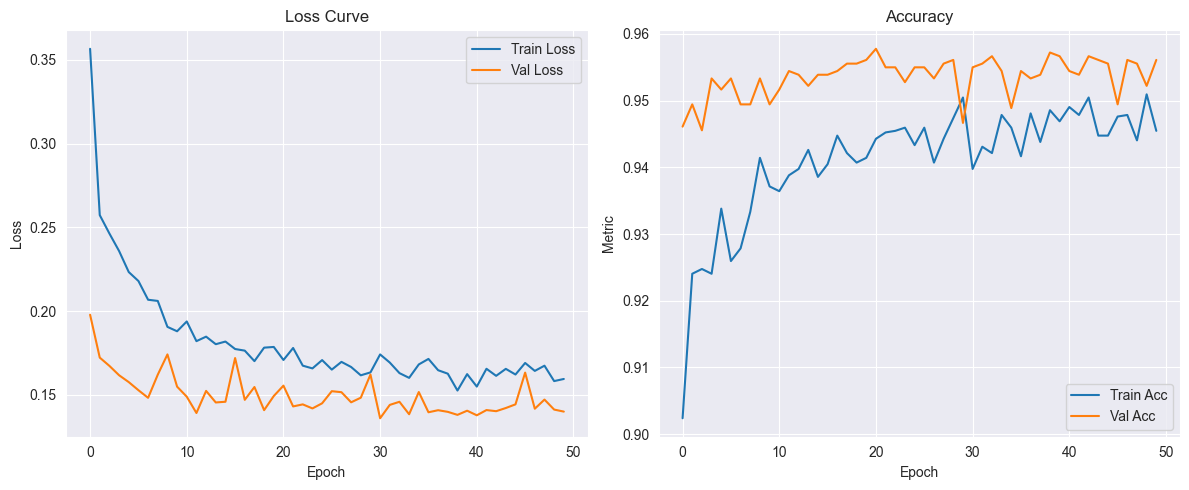


Final Test Evaluation:
Accuracy: 0.9750
F1 Score (macro): 0.9750
F1 Score (weighted): 0.9750

Per-Class Classification Report:
              precision    recall  f1-score   support

           0     0.9524    1.0000    0.9756        20
           1     1.0000    0.9500    0.9744        20

    accuracy                         0.9750        40
   macro avg     0.9762    0.9750    0.9750        40
weighted avg     0.9762    0.9750    0.9750        40

Confusion Matrix:
[[20  0]
 [ 1 19]]


In [267]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import shuffle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
# # 
# # # Custom Dataset
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
# 
# Autoencoder with classifier head
class AutoencoderClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, bottleneck_dim=64, num_classes=2, dropout_rate=0.2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, bottleneck_dim),
            nn.BatchNorm1d(bottleneck_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
        self.classifier = nn.Linear(bottleneck_dim, num_classes)

    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        logits = self.classifier(encoded)
        return reconstructed, logits

# Load your train_x, train_y, val_x, val_y, test_x, test_y before this point
train_dataset = TabularDataset(train_x, train_y)
val_dataset = TabularDataset(val_x, val_y)
test_dataset = TabularDataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Model setup
input_dim = train_x.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoencoderClassifier(input_dim, dropout_rate=0.2).to(device)

criterion_recon = nn.MSELoss()
criterion_cls = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

# For plotting
train_losses, val_losses = [], []
train_accs, val_accs = [], []
val_f1s = []

# Training loop
best_val_f1 = 0
for epoch in range(50):
    model.train()
    total_loss = 0
    total_recon_loss = 0
    total_cls_loss = 0
    correct = 0
    total = 0
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/50", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        recon, logits = model(xb)
        recon_loss = criterion_recon(recon, xb)
        cls_loss = criterion_cls(logits, yb)
        loss = 0.3 * recon_loss + 0.7 * cls_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_cls_loss += cls_loss.item()
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    train_acc = correct / total

    # Validation loop
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            recon, logits = model(xb)
            recon_loss = criterion_recon(recon, xb)
            cls_loss = criterion_cls(logits, yb)
            loss = 0.3 * recon_loss + 0.7 * cls_loss

            val_loss += loss.item()
            preds = logits.argmax(1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(yb.cpu().numpy())
            val_correct += (preds == yb).sum().item()
            val_total += yb.size(0)

    val_acc = val_correct / val_total
    val_f1 = f1_score(val_labels, val_preds, average='macro')
    scheduler.step(val_f1)

    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_model.pt")

    # Log for plotting
    train_losses.append(total_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)

    print(f"\nEpoch {epoch+1} Summary:")
    print(f"Train Acc: {train_acc:.4f}, Train Loss: {train_losses[-1]:.4f}")
    print(f"Val Acc: {val_acc:.4f}, Val F1 (macro): {val_f1:.4f}, Val Loss: {val_losses[-1]:.4f}")

# Plotting curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig("training_curves_ae.pdf", dpi=300)
plt.show()

# Final evaluation on test set
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        _, logits = model(xb)
        preds = logits.argmax(1).cpu().numpy()
        test_preds.extend(preds)
        test_labels.extend(yb.numpy())

print("\nFinal Test Evaluation:")
print(f"Accuracy: {accuracy_score(test_labels, test_preds):.4f}")
print(f"F1 Score (macro): {f1_score(test_labels, test_preds, average='macro'):.4f}")
print(f"F1 Score (weighted): {f1_score(test_labels, test_preds, average='weighted'):.4f}")
print("\nPer-Class Classification Report:")
print(classification_report(test_labels, test_preds, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(test_labels, test_preds))



Epoch 1 Summary:
Train Acc: 0.8314, Train Loss: 0.4163
Val Acc: 0.9067, Val F1 (macro): 0.9063, Val Loss: 0.2685



Epoch 2 Summary:
Train Acc: 0.9117, Train Loss: 0.2354
Val Acc: 0.9294, Val F1 (macro): 0.9293, Val Loss: 0.2088



Epoch 3 Summary:
Train Acc: 0.9236, Train Loss: 0.1995
Val Acc: 0.9406, Val F1 (macro): 0.9405, Val Loss: 0.1831



Epoch 4 Summary:
Train Acc: 0.9362, Train Loss: 0.1790
Val Acc: 0.9450, Val F1 (macro): 0.9449, Val Loss: 0.1698



Epoch 5 Summary:
Train Acc: 0.9398, Train Loss: 0.1679
Val Acc: 0.9500, Val F1 (macro): 0.9499, Val Loss: 0.1610



Epoch 6 Summary:
Train Acc: 0.9414, Train Loss: 0.1613
Val Acc: 0.9461, Val F1 (macro): 0.9460, Val Loss: 0.1567



Epoch 7 Summary:
Train Acc: 0.9414, Train Loss: 0.1569
Val Acc: 0.9539, Val F1 (macro): 0.9539, Val Loss: 0.1504



Epoch 8 Summary:
Train Acc: 0.9414, Train Loss: 0.1547
Val Acc: 0.9533, Val F1 (macro): 0.9533, Val Loss: 0.1475



Epoch 9 Summary:
Train Acc: 0.9481, Train Loss: 0.1475
Val Acc: 0.9544, Val F1 (macro): 0.9544, Val Loss: 0.1437



Epoch 10 Summary:
Train Acc: 0.9438, Train Loss: 0.1505
Val Acc: 0.9528, Val F1 (macro): 0.9527, Val Loss: 0.1425



Epoch 11 Summary:
Train Acc: 0.9474, Train Loss: 0.1463
Val Acc: 0.9544, Val F1 (macro): 0.9544, Val Loss: 0.1430



Epoch 12 Summary:
Train Acc: 0.9481, Train Loss: 0.1473
Val Acc: 0.9556, Val F1 (macro): 0.9555, Val Loss: 0.1392



Epoch 13 Summary:
Train Acc: 0.9512, Train Loss: 0.1357
Val Acc: 0.9550, Val F1 (macro): 0.9550, Val Loss: 0.1381



Epoch 14 Summary:
Train Acc: 0.9495, Train Loss: 0.1415
Val Acc: 0.9567, Val F1 (macro): 0.9566, Val Loss: 0.1364



Epoch 15 Summary:
Train Acc: 0.9460, Train Loss: 0.1388
Val Acc: 0.9556, Val F1 (macro): 0.9555, Val Loss: 0.1363



Epoch 16 Summary:
Train Acc: 0.9495, Train Loss: 0.1376
Val Acc: 0.9561, Val F1 (macro): 0.9561, Val Loss: 0.1336



Epoch 17 Summary:
Train Acc: 0.9476, Train Loss: 0.1332
Val Acc: 0.9544, Val F1 (macro): 0.9544, Val Loss: 0.1345



Epoch 18 Summary:
Train Acc: 0.9538, Train Loss: 0.1327
Val Acc: 0.9556, Val F1 (macro): 0.9555, Val Loss: 0.1333



Epoch 19 Summary:
Train Acc: 0.9505, Train Loss: 0.1365
Val Acc: 0.9550, Val F1 (macro): 0.9550, Val Loss: 0.1334



Epoch 20 Summary:
Train Acc: 0.9476, Train Loss: 0.1360
Val Acc: 0.9561, Val F1 (macro): 0.9561, Val Loss: 0.1328


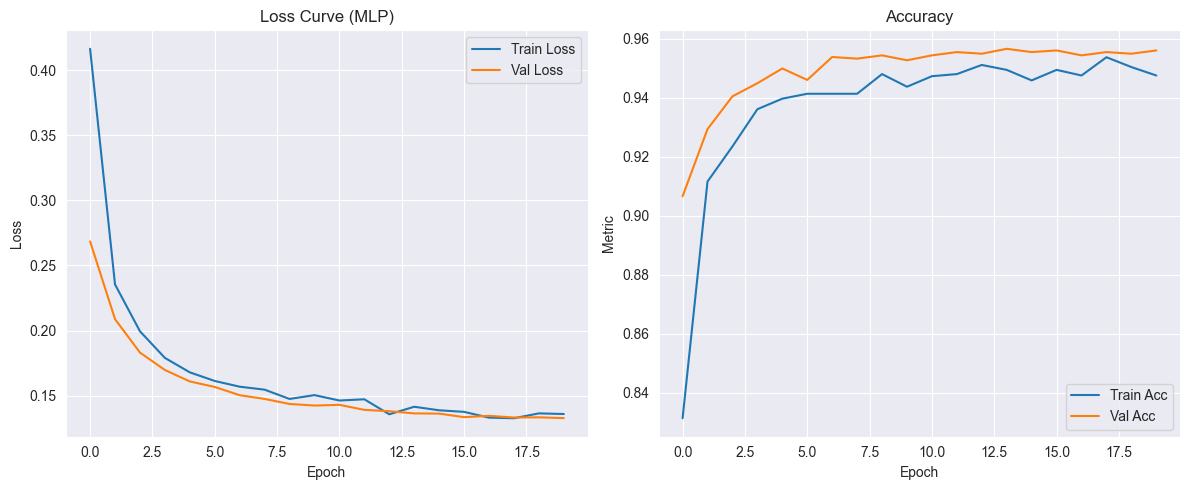


Final Test Evaluation (MLP):
Accuracy: 0.9750
F1 Score (macro): 0.9750
F1 Score (weighted): 0.9750

Classification Report:
              precision    recall  f1-score   support

           0     0.9524    1.0000    0.9756        20
           1     1.0000    0.9500    0.9744        20

    accuracy                         0.9750        40
   macro avg     0.9762    0.9750    0.9750        40
weighted avg     0.9762    0.9750    0.9750        40

Confusion Matrix:
[[20  0]
 [ 1 19]]


In [268]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Simple MLP model
import torch
import torch.nn as nn

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes=2, dropout_rate=0.2):
        """
        Args:
            input_dim (int): Number of input features.
            hidden_dims (list[int]): Sizes of hidden layers, e.g., [128, 64].
            num_classes (int): Number of output classes.
            dropout_rate (float): Dropout probability.
        """
        super(MLPClassifier, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        
        self.model = self._build_model()
    
    def _build_model(self):
        layers = []
        dims = [self.input_dim] + self.hidden_dims
        
        for i in range(len(self.hidden_dims)):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.BatchNorm1d(dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(self.dropout_rate))
        
        # Output layer
        layers.append(nn.Linear(dims[-1], self.num_classes))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


train_dataset = TabularDataset(train_x, train_y)
val_dataset = TabularDataset(val_x, val_y)
test_dataset = TabularDataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize model
mlp_model = MLPClassifier(input_dim=train_x.shape[1], hidden_dims=[64]).to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
# For plotting
train_losses, val_losses = [], []
train_accs, val_accs = [], []
val_f1s = []

# Training loop
best_val_f1 = 0
for epoch in range(20):
    mlp_model.train()
    total_loss, correct, total = 0, 0, 0
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/20", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        logits = mlp_model(xb)
        loss = criterion(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    train_acc = correct / total

    # Validation
    mlp_model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = mlp_model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item()

            preds = logits.argmax(1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(yb.cpu().numpy())
            val_correct += (preds == yb).sum().item()
            val_total += yb.size(0)

    val_acc = val_correct / val_total
    val_f1 = f1_score(val_labels, val_preds, average='macro')
    scheduler.step(val_loss)

    # Log for plotting
    train_losses.append(total_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"Train Acc: {train_acc:.4f}, Train Loss: {total_loss/len(train_loader):.4f}")
    print(f"Val Acc: {val_acc:.4f}, Val F1 (macro): {val_f1:.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(mlp_model.state_dict(), "best_mlp_model.pt")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve (MLP)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig("training_curves_mlp.pdf", dpi=300)
plt.show()
# Final evaluation on test set
mlp_model.load_state_dict(torch.load("best_mlp_model.pt"))
mlp_model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = mlp_model(xb)
        preds = logits.argmax(1).cpu().numpy()
        test_preds.extend(preds)
        test_labels.extend(yb.numpy())

print("\nFinal Test Evaluation (MLP):")
print(f"Accuracy: {accuracy_score(test_labels, test_preds):.4f}")
print(f"F1 Score (macro): {f1_score(test_labels, test_preds, average='macro'):.4f}")
print(f"F1 Score (weighted): {f1_score(test_labels, test_preds, average='weighted'):.4f}")

print("\nClassification Report:")
print(classification_report(test_labels, test_preds, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(test_labels, test_preds))


In [269]:
feature_columns = [
        'ClksThisMin', 'medianKHz', 'avSPL', 'avPkAt',
        'AvPRF', 'avEndF', 'tWUTrisk', 'nActualClx', 'nRisingIPIs',
        'TrDur_us', 'nICIrising',
        'MinICI_us', 'midpointICI', 'MaxICI_us', 'ClkNofMinICI',
        'ClkNofMaxICI', 'NofClstrs',
        'avClstrNx8', 'avPkIPI', 'BeforeIPIratio', 'PreIPIratio',
        'Post1IPIratio', 'Post2IPIratio', 'EndIPIratio'
    ]



In [270]:
from sklearn.ensemble import IsolationForest

def filter_unlabeled(isolation, meta):
    iso = IsolationForest(contamination=0.08, random_state=42)
    outliers = iso.fit_predict(isolation)
    filtered_signals = isolation[np.where(outliers == -1)[0]]
    filtered_meta = meta[np.where(outliers == -1)[0]]
    return filtered_signals, filtered_meta

filtered_unlabeled, filtered_meta = filter_unlabeled(unlabeled_x, unlabeled_meta)
# idx_class_1 = np.where(preds == 1)[0][0]

# print(f"Waterfall plot for predicted class 0 (index {idx_class_0}):")
# shap.plots.waterfall(shap.Explanation(
#     values=shap_values[idx_class_0],
#     base_values=explainer.expected_value,
#     data=isolation[idx_class_0],
#     feature_names=feature_columns,
# ))
# 
# print(f"Waterfall plot for predicted class 1 (index {idx_class_1}):")
# shap.plots.waterfall(shap.Explanation(
#     values=shap_values[idx_class_1],
#     base_values=explainer.expected_value,
#     data=isolation[idx_class_1],
#     feature_names=feature_columns
# ))
print(len(unlabeled_x), len(filtered_unlabeled))

5232172 418574


In [271]:
import numpy as np

# def predict(model, x, device='cuda'):
#     """
#     Predict class labels for input x.
#     Args:
#         model (nn.Module): Trained model.
#         x (torch.Tensor or np.ndarray): Input data.
#         device (str): Device to run the model on.
#     Returns:
#         np.ndarray: Predicted class labels.
#     """
#     model.eval()
#     if isinstance(x, np.ndarray):
#         x = torch.from_numpy(x).float()
#     x = x.to(device)
#     with torch.no_grad():
#         logits = model(x)
#         preds = logits.argmax(dim=1)
#     return preds.cpu().numpy()
# 
# def predict_proba(model, x, device='cuda'):
#     """
#     Predict class probabilities for input x.
#     Args:
#         model (nn.Module): Trained model.
#         x (torch.Tensor or np.ndarray): Input data.
#         device (str): Device to run the model on.
#     Returns:
#         np.ndarray: Predicted class probabilities (softmax output).
#     """
#     model.eval()
#     if isinstance(x, np.ndarray):
#         x = torch.from_numpy(x).float()
#     x = x.to(device)
#     with torch.no_grad():
#         logits = model(x)
#         probs = torch.softmax(logits, dim=1)
#     return probs.cpu().numpy()

def predict(model, x, device='cuda'):
    """
    Predict class labels for input x.
    Args:
        model (nn.Module): Trained model that returns (features, logits).
        x (torch.Tensor or np.ndarray): Input data.
        device (str): Device to run the model on.
    Returns:
        np.ndarray: Predicted class labels.
    """
    model.eval()
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x).float()
    x = x.to(device)
    with torch.no_grad():
        _, logits = model(x)
        preds = logits.argmax(dim=1)
    return preds.cpu().numpy()
def predict_proba(model, x, device='cuda'):
    """
    Predict class probabilities for input x.
    Args:
        model (nn.Module): Trained model that returns (features, logits).
        x (torch.Tensor or np.ndarray): Input data.
        device (str): Device to run the model on.
    Returns:
        np.ndarray: Predicted class probabilities (softmax output).
    """
    model.eval()
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x).float()
    x = x.to(device)
    with torch.no_grad():
        _, logits = model(x)
        probs = torch.softmax(logits, dim=1)
    return probs.cpu().numpy()


In [272]:
from collections import Counter
import numpy as np

# === Predict on full unlabeled set ===
filtered_unlabeled = scaler.transform(filtered_unlabeled)
unlabeled_probs = predict_proba(model, filtered_unlabeled, device=device)
unlabeled_preds = predict(model, filtered_unlabeled, device=device)

confidence_threshold = 0.95

# Generate final predictions and mask for confident samples
final_unlabeled_preds = []
final_unlabeled_meta = []
for pred, prob, meta in zip(unlabeled_preds, unlabeled_probs, filtered_meta):
    if max(prob) >= confidence_threshold:
        final_unlabeled_preds.append(pred)
        final_unlabeled_meta.append(meta)
    else:
        final_unlabeled_preds.append(2)  # Assign to class 2 (noise)
        final_unlabeled_meta.append(meta)

final_unlabeled_preds = np.array(final_unlabeled_preds)
final_unlabeled_meta = np.array(final_unlabeled_meta)

# === Print stats ===
distribution = Counter(final_unlabeled_preds)
total = len(final_unlabeled_preds)
print("\nFinal Unlabeled Predictions Distribution:")
for label, count in distribution.items():
    pct = (count / total) * 100
    print(f"Class {label}: {count} ({pct:.2f}%)")
print(len(final_unlabeled_preds), len(final_unlabeled_meta))


Final Unlabeled Predictions Distribution:
Class 0: 211890 (50.62%)
Class 2: 141060 (33.70%)
Class 1: 65624 (15.68%)
418574 418574


In [273]:
def postprocess_class1_sequences(unlabeled_x, unlabeled_y, unlabeled_meta, time_gap_threshold_us=15_000_000):
    feature_column_names = [
        'ClksThisMin', 'medianKHz', 'avSPL', 'avPkAt',
        'AvPRF', 'avEndF', 'tWUTrisk', 'nActualClx', 'nRisingIPIs',
        'TrDur_us', 'nICIrising',
        'MinICI_us', 'midpointICI', 'MaxICI_us', 'ClkNofMinICI',
        'ClkNofMaxICI', 'NofClstrs',
        'avClstrNx8', 'avPkIPI', 'BeforeIPIratio', 'PreIPIratio',
        'Post1IPIratio', 'Post2IPIratio', 'EndIPIratio'
    ]
    trdur_idx =  feature_column_names.index('TrDur_us')

    data_by_location = defaultdict(list)
    for idx, meta in enumerate(unlabeled_meta):
        location, minute_str, micro_str = meta
        start_us = np.int64(int(minute_str)) * 60 * 1_000_000 + np.int64(int(micro_str))
        duration_us = np.int64(unlabeled_x[idx, trdur_idx])
        end_us = start_us + duration_us
        data_by_location[location].append((start_us, end_us, idx))
    for loc in data_by_location:
        data_by_location[loc].sort()
    new_labels = unlabeled_y.copy()

    for loc, entries in data_by_location.items():
        class1_entries = [(s, e, i) for (s, e, i) in entries if unlabeled_y[i] == 1]
        class1_entries.sort()

        current_sequence = []
        for j in range(len(class1_entries)):
            s, e, idx = class1_entries[j]
            if not current_sequence:
                current_sequence.append((s, e, idx))
            else:
                prev_s, prev_e, _ = current_sequence[-1]
                if s - prev_e <= time_gap_threshold_us:
                    current_sequence.append((s, e, idx))
                else:
                    if len(current_sequence) >= 2:
                        for _, _, seq_idx in current_sequence:
                            new_labels[seq_idx] = 1
                    else:
                        for _, _, seq_idx in current_sequence:
                            new_labels[seq_idx] = 2
                    current_sequence = [(s, e, idx)]

        if current_sequence:
            if len(current_sequence) >= 2:
                for _, _, seq_idx in current_sequence:
                    new_labels[seq_idx] = 1
            else:
                for _, _, seq_idx in current_sequence:
                    new_labels[seq_idx] = 2

    return new_labels

new_labels = postprocess_class1_sequences(filtered_unlabeled, final_unlabeled_preds, filtered_meta)

In [274]:
distribution = Counter(new_labels)
total = len(new_labels)
print("\nFinal Unlabeled Predictions Distribution:")
for label, count in distribution.items():
    pct = (count / total) * 100
    print(f"Class {label}: {count} ({pct:.2f}%)")


Final Unlabeled Predictions Distribution:
Class 0: 211890 (50.62%)
Class 2: 182645 (43.64%)
Class 1: 24039 (5.74%)


In [275]:
data = np.load("fixed_click_dataset.npz", allow_pickle=True)
labeled_sx = data['labeled_x']
labeled_sy = data['labeled_y']
signal_x = data['unlabeled_x']
signal_meta = data['unlabeled_meta']
labeled_smeta = data['labeled_meta']

In [276]:
print(signal_meta[0], final_unlabeled_meta[0])

['B Balchik' 63575466 12531720] ['B Balchik' '63575468' '57852715']


In [277]:
# special_areas = ['U Dzha Bay', 'U Dzha Sea']
# 
# signal_meta = np.array(signal_meta)
# def extract_area_name(entry):
#     entry_str = str(entry)
#     for area in special_areas:
#         if entry_str.startswith(area):
#             return area
#     match = re.match(r'^(\w+ \w+)', entry_str)
#     return match.group(1) if match else entry_str
# 
# vectorized_extractor = np.vectorize(extract_area_name)
# 
# clean_unlabeled_meta = vectorized_extractor(signal_meta[:, 0])
# meta_signal = np.column_stack((clean_unlabeled_meta, signal_meta[:, 1:3]))

In [278]:
def save_labeled_visuals_by_location(
    labeled_x, labeled_y, labeled_meta,
    signal_x, signal_meta,
    location_filter='U Dzha Bay',
    save_dir='labeled_data_visuals',
    save_waveform_plot=True,
    max_per_class=30
):
    os.makedirs(save_dir, exist_ok=True)

    feature_column_names = [
        'ClksThisMin', 'medianKHz', 'avSPL', 'avPkAt',
        'AvPRF', 'avEndF', 'tWUTrisk', 'nActualClx', 'nRisingIPIs',
        'TrDur_us', 'nICIrising',
        'MinICI_us', 'midpointICI', 'MaxICI_us', 'ClkNofMinICI',
        'ClkNofMaxICI', 'NofClstrs',
        'avClstrNx8', 'avPkIPI', 'BeforeIPIratio', 'PreIPIratio',
        'Post1IPIratio', 'Post2IPIratio', 'EndIPIratio'
    ]

    class_dirs = {
        0: os.path.join(save_dir, "class_0"),
        1: os.path.join(save_dir, "class_1"),
        2: os.path.join(save_dir, "noise")
    }
    for d in class_dirs.values():
        os.makedirs(d, exist_ok=True)

    filtered = [
        (x, y, meta) for x, y, meta in zip(labeled_x, labeled_y, labeled_meta)
        if meta[0] == location_filter
    ]

    if not filtered:
        print(f"No labeled instances found for location: {location_filter}")
        return

    signal_lookup = {tuple(m): s for s, m in zip(signal_x, signal_meta)}
    saved_counts = {0: 0, 1: 0, 2: 0}

    for i, (x, y, meta) in enumerate(tqdm(filtered)):
        identity = tuple([meta[0], int(meta[1]), int(meta[2])])
        raw_signal = signal_lookup.get(identity, None)

        if raw_signal is None:
            continue

        final_class = y if y in [0, 1] else 2
        if saved_counts[final_class] >= max_per_class:
            continue

        label_dir = class_dirs[final_class]
        base_name = f"{i}_{identity[0].replace(' ', '_')}_{identity[1]}_{identity[2]}"

        df_feat = pd.DataFrame([x, meta], columns=feature_column_names)
        df_feat.to_csv(os.path.join(label_dir, f"{base_name}_features.csv"), index=False)

        if save_waveform_plot:
            plt.figure(figsize=(6, 3))
            plt.plot(raw_signal, lw=1)
            plt.title(f"Label: Class {final_class}")
            plt.xlabel("Time (sampled)")
            plt.ylabel("Clk/s")
            plt.tight_layout()
            plt.savefig(os.path.join(label_dir, f"{base_name}_waveform.png"))
            plt.close()

        saved_counts[final_class] += 1

        if all(saved_counts[c] >= max_per_class for c in saved_counts):
            print("Saved max limit for all classes. Stopping.")
            break

    print(f"Saved labeled data for location: {location_filter} to: {save_dir}")
    print(f"Saved counts: {saved_counts}")

save_labeled_visuals_by_location(
    filtered_unlabeled, new_labels, final_unlabeled_meta,
    signal_x, signal_meta,
    location_filter='B Ravda',
    save_dir='data_files/Ravda_data_visuals_2',
    save_waveform_plot=True,
    max_per_class=100
)

  2%|▏         | 988/59559 [01:12<1:11:35, 13.64it/s]

Saved max limit for all classes. Stopping.
Saved labeled data for location: B Ravda to: data_files/Ravda_data_visuals_2
Saved counts: {0: 100, 1: 100, 2: 100}


In [279]:
# shap.summary_plot(shap_values, isolation, feature_names=feature_columns, plot_type="bar")


In [280]:
# from sklearn.ensemble import IsolationForest
# import matplotlib.pyplot as plt
# import numpy as np
# import umap
# 
# def plot_umap(labeled_x, unlabeled_x=None, labeled_y=None, title="UMAP Visualization", figsize=(8, 6), 
#               n_neighbors=15, min_dist=0.1, random_state=42, save_path=None, save_path_outliers=None, 
#               perform_outlier_detection=False):
#     """Plots and optionally saves UMAP projection and outlier detection with Isolation Forest."""
#     
#     if unlabeled_x is not None:
#         combined_x = np.vstack((labeled_x, unlabeled_x))
#     else:
#         combined_x = labeled_x
# 
#     # Step 1: Compute UMAP projection
#     reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
#     reduced = reducer.fit_transform(combined_x)
# 
#     # Step 2: Plot normal UMAP
#     plt.figure(figsize=figsize)
#     if unlabeled_x is not None:
#         n_labeled = len(labeled_x)
#         unlabeled_reduced = reduced[n_labeled:]
#         labeled_reduced = reduced[:n_labeled]
#         plt.scatter(unlabeled_reduced[:, 0], unlabeled_reduced[:, 1], c='gray', alpha=0.4, label='Unlabeled', s=20)
#         if labeled_y is not None:
#             for class_id in np.unique(labeled_y):
#                 idx = labeled_y == class_id
#                 plt.scatter(labeled_reduced[idx, 0], labeled_reduced[idx, 1], label=f'Class {class_id}', s=30)
#         else:
#             plt.scatter(labeled_reduced[:, 0], labeled_reduced[:, 1], label='Labeled', s=30)
#     else:
#         if labeled_y is not None:
#             for class_id in np.unique(labeled_y):
#                 idx = labeled_y == class_id
#                 plt.scatter(reduced[idx, 0], reduced[idx, 1], label=f'Class {class_id}', s=30)
#         else:
#             plt.scatter(reduced[:, 0], reduced[:, 1], s=30)
# 
#     plt.title(title)
#     plt.xlabel("UMAP 1")
#     plt.ylabel("UMAP 2")
#     plt.legend()
#     plt.grid(True)
#     
#     if save_path:
#         plt.savefig(save_path, bbox_inches='tight', format='pdf')
#         print(f"UMAP plot saved to {save_path}")
#     else:
#         plt.show()
# 
#     # Step 3: Outlier detection (if requested)
#     if perform_outlier_detection and save_path_outliers:
#         iso = IsolationForest(contamination=0.05, random_state=random_state)
#         outliers = iso.fit_predict(combined_x)
#         is_outlier = (outliers == -1)
# 
#         plt.figure(figsize=figsize)
#         plt.scatter(reduced[~is_outlier, 0], reduced[~is_outlier, 1], c='blue', label='Inlier', s=5, alpha=0.6)
#         plt.scatter(reduced[is_outlier, 0], reduced[is_outlier, 1], c='red', label='Outlier', s=10)
#         plt.title("UMAP with Outlier Detection (Isolation Forest)")
#         plt.xlabel("UMAP 1")
#         plt.ylabel("UMAP 2")
#         plt.legend()
#         plt.grid(True)
# 
#         plt.savefig(save_path_outliers, bbox_inches='tight', format='pdf')
#         print(f"UMAP with outliers plot saved to {save_path_outliers}")
# 
# plot_umap(labeled_x, unlabeled_x[:500000], labeled_y, title="UMAP Visualization", save_path_outliers="umap_plot_outliers.pdf", save_path="umap_plot.pdf", perform_outlier_detection=True)


In [281]:
# shap.plots.heatmap(shap.Explanation(
#     values=shap_values,
#     base_values=explainer.expected_value,
#     data=isolation,
#     feature_names=feature_columns
# ))

In [282]:
# import pandas as pd
# 
# # Create a DataFrame to make this easier
# df = pd.DataFrame(isolation, columns=feature_columns)
# df['predicted_class'] = preds  # from your IsolationForest
# 
# # Group by class and calculate mean
# feature_means_by_class = df.groupby('predicted_class').mean()
# 
# feature_means_by_class
